In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn import tree
from mlxtend.plotting import plot_decision_regions

# 데이터 로드

In [2]:
data = pd.read_csv('/kaggle/input/luke-hair-loss-dataset/Luke_hair_loss_documentation.csv')

# 결측치 대체 및 인코딩

In [3]:
# school_assesssment 결측치 처리
data['school_assesssment'] = data['school_assesssment'].fillna(0)  # 미리 'None'에 해당하는 값인 0으로 채움
data['school_assesssment'] = data['school_assesssment'].map({0: 0, 'Individual ass': 1, 'Team ass': 2, 'Final exam revision': 3})

# dandruff 결측치 처리
data['dandruff'] = data['dandruff'].fillna('None')
data['dandruff'] = data['dandruff'].map({'None': 0, 'Few': 1, 'Many': 2})

# hair_grease 결측치 처리
median_hair_grease = data['hair_grease'].median()
data['hair_grease'] = data['hair_grease'].fillna(median_hair_grease)

# 남은 결측치 전방 채우기
data = data.ffill()  # 이전 값을 사용하여 결측치 채우기

# 나머지 범주형 데이터 인코딩

In [4]:
# 매핑 사전 설정
hair_loss_mapping = {'Few': 0, 'Medium': 1, 'Many': 2, 'A lot': 3}
stress_level_mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3}

# 데이터 매핑
data['hair_loss'] = data['hair_loss'].map(hair_loss_mapping)
data['stress_level'] = data['stress_level'].map(stress_level_mapping)

# 다른 범주형 열에 대해 LabelEncoder 사용
label_encoders = {}
categorical_columns = ['pressure_level', 'shampoo_brand', 'swimming', 'hair_washing']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# 특성 및 타겟 분리

In [5]:
X = data.drop(columns=['date ', 'hair_loss'])
y = data['hair_loss']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# AdaBoost 기본 설정으로 모델 생성

In [6]:
model = AdaBoostClassifier(random_state=42)
model.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

# 하이퍼파라미터 그리드 설정

In [7]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 1, 10]
}

# 그리드 서치로 최적의 매개변수 탐색
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy')

# 최적의 매개변수로 모델 평가

In [8]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f'Accuracy with best parameters: {accuracy_score(y_test, y_pred)}')

Accuracy with best parameters: 0.775


# 교차 검증

In [9]:
cross_val_scores = cross_val_score(best_model, X, y, cv=5)
print(f'Cross-validation scores: {cross_val_scores}')
print(f'Mean cross-validation score: {cross_val_scores.mean()}')

Cross-validation scores: [0.85   0.6    0.6875 0.6625 0.8375]
Mean cross-validation score: 0.7275


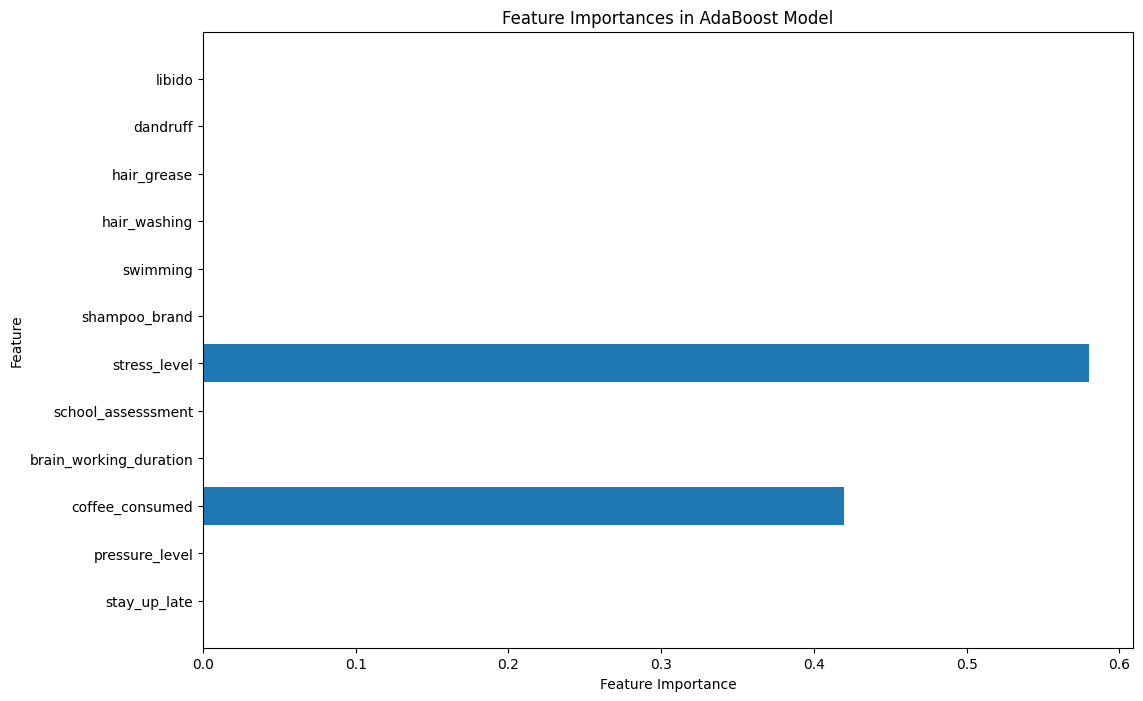

In [10]:
# 특성 중요도 추출
feature_importances = best_model.feature_importances_

# 특성 중요도 시각화
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), X.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in AdaBoost Model')
plt.show()

# 모델의 첫 번째 결정 트리 시각화

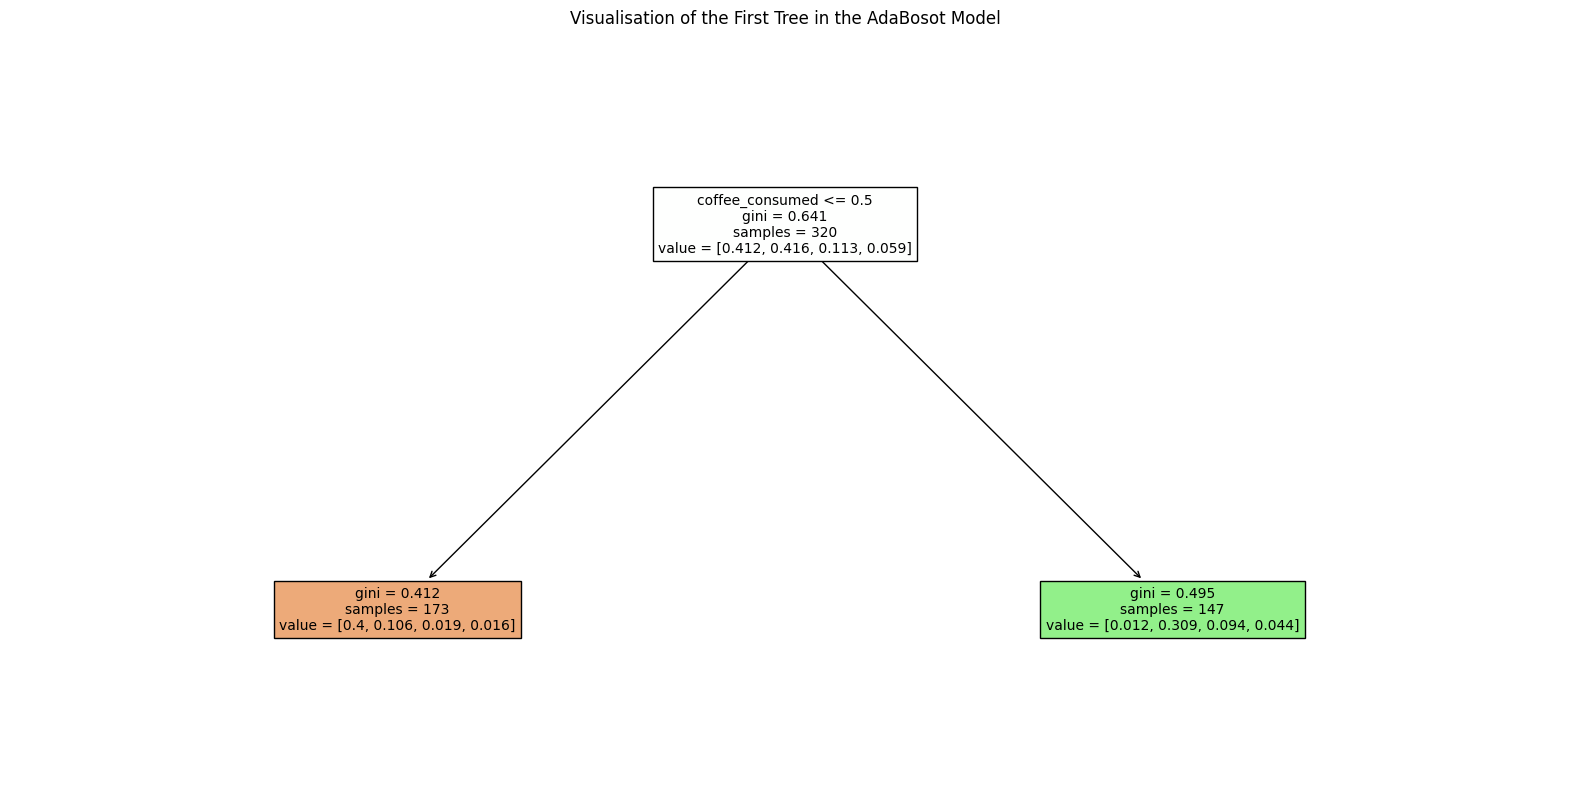

In [11]:
plt.figure(figsize=(20, 10))
tree.plot_tree(best_model.estimators_[0], filled=True, feature_names=X.columns, fontsize=10)
plt.title('Visualisation of the First Tree in the AdaBosot Model')
plt.show()

# AdaBoost 모델의 모든 결정 트리를 시각화

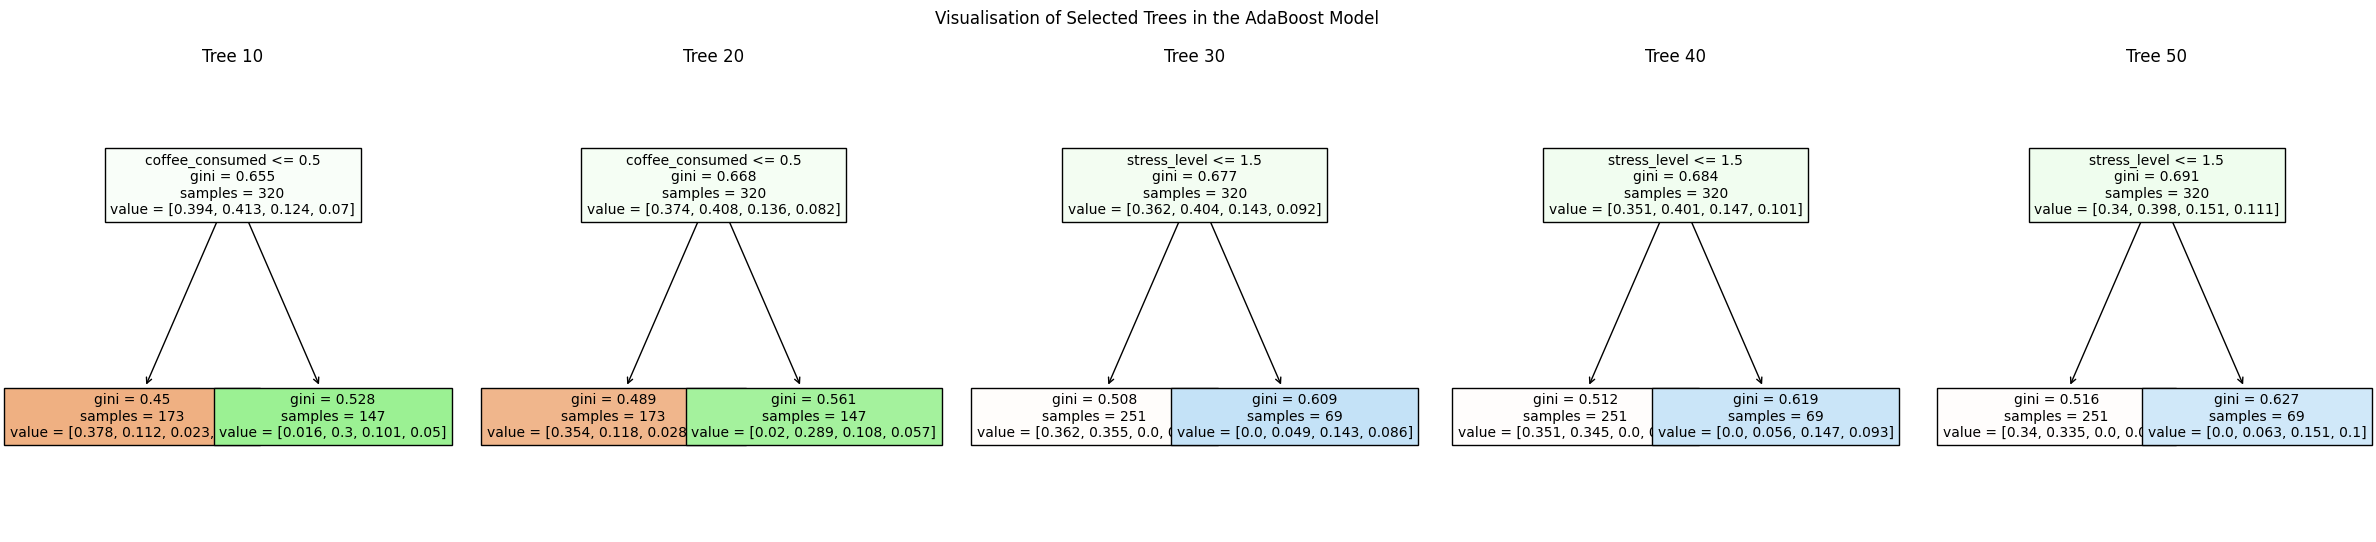

In [12]:
# 선택할 트리의 인덱스: 10, 20, 30, 40, 50 (50개 중 10개 간격)
tree_indices = [9, 19, 29, 39, 49]

# 플롯의 크기 설정
plt.figure(figsize=(30, 6))  # 전체 플롯의 크기

# 각 트리를 서브플롯으로 그리기
for i, tree_index in enumerate(tree_indices):
    ax = plt.subplot(1, 5, i+1)  # 1행 5열의 서브플롯 생성
    tree.plot_tree(best_model.estimators_[tree_index], filled=True, feature_names=X.columns, ax=ax, fontsize=10)
    ax.set_title(f'Tree {tree_index + 1}')

# 전체 플롯의 제목 설정
plt.suptitle('Visualisation of Selected Trees in the AdaBoost Model')

# 플롯 보이기
plt.show()

# 특성 중요도 추이

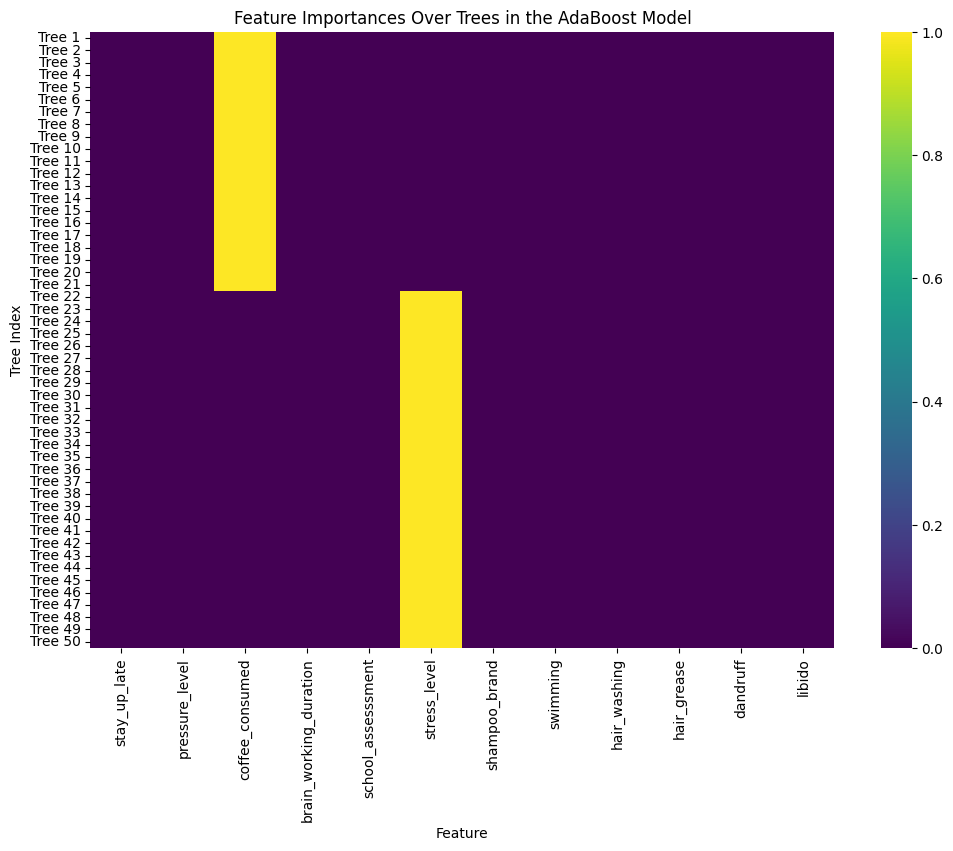

In [13]:
# 각 트리의 특성 중요도 수집
feature_importances = np.array([est.feature_importances_ for est in best_model.estimators_])

# 히트맵 생성
plt.figure(figsize=(12, 8))
sns.heatmap(feature_importances, cmap='viridis', yticklabels=[f'Tree {i+1}' for i in range(feature_importances.shape[0])], xticklabels=X.columns)
plt.title('Feature Importances Over Trees in the AdaBoost Model')
plt.xlabel('Feature')
plt.ylabel('Tree Index')
plt.show()

# 모델 예측의 시간 진화

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


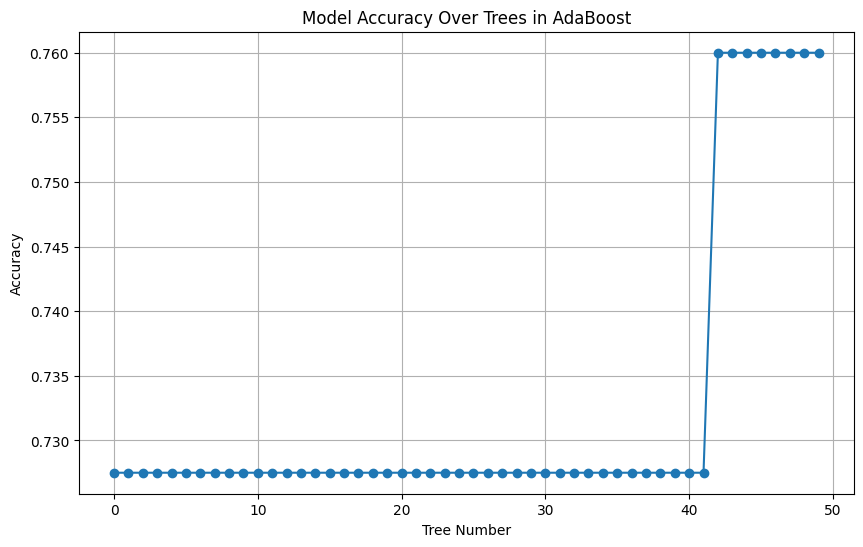

In [14]:
# 각 트리의 예측과 정확도 계산
accuracies = []
for y_pred in best_model.staged_predict(X):
    accuracies.append(accuracy_score(y, y_pred))

# 정확도 시각화
plt.figure(figsize=(10, 6))
plt.plot(accuracies, marker='o')
plt.title('Model Accuracy Over Trees in AdaBoost')
plt.xlabel('Tree Number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 결정 경계 시각화

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


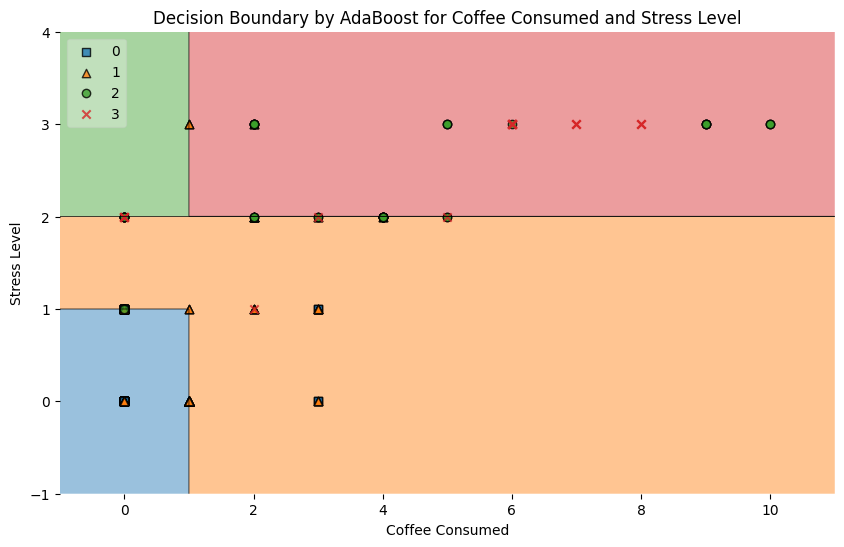

In [15]:
# 데이터 선택
X_reduced = X[['coffee_consumed', 'stress_level']]
y_array = y.to_numpy()

# AdaBoost 모델 다시 학습
retrained_ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=0)
retrained_ada_model.fit(X_reduced, y_array)

# 결정 경계 시각화
plt.figure(figsize=(10, 6))
plot_decision_regions(X_reduced.to_numpy(), y_array, clf=retrained_ada_model, legend=2)
plt.title('Decision Boundary by AdaBoost for Coffee Consumed and Stress Level')
plt.xlabel('Coffee Consumed')
plt.ylabel('Stress Level')
plt.show()